In [2]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

tf.compat.v1.enable_eager_execution()

2022-12-12 18:00:06.019951: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-12 18:00:06.021093: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-12 18:00:06.021103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### Paths

In [4]:
celeba_path = Path('../../../Dataset/img_celeba_cropped/')
celeba_identity_path = Path('../../Dataset/celeb_identity_processed.txt')

precalculated_triplets_path = Path('../../Dataset/triplets_27k.csv')

### Hyperparameters

In [5]:
triplets_count = 5000

train_size = 0.7

network_input_shape = (224, 224, 3)

batch_size = 16
lr = 1e-6

### a) Creating triplets

In [6]:
df_identity = pd.read_csv(
    celeba_identity_path,
    sep=",",
    names=["image", "identity"],
    header=0,
    dtype=str
)

In [7]:
def create_n_triplets(df_identity, n):
    triplets = []

    for triplet in range(n):
        anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)

        keepGoing = True
        while (keepGoing):
            anchor, positive = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True)
            keepGoing = (anchor == positive)

        negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)

        anchor = str(celeba_path) + '/' + anchor
        positive = str(celeba_path) + '/' + positive
        negative = str(celeba_path) + '/' + negative

        triplets.append([anchor, positive, negative])

    return pd.DataFrame(triplets, columns=['anchor', 'positive', 'negative'])

In [8]:
triplets = create_n_triplets(df_identity, triplets_count)
triplets.head()

,anchor,positive,negative
0,../../../Dataset/img_celeba_cropped/091466.jpg,../../../Dataset/img_celeba_cropped/084435.jpg,../../../Dataset/img_celeba_cropped/070080.jpg
1,../../../Dataset/img_celeba_cropped/100875.jpg,../../../Dataset/img_celeba_cropped/022109.jpg,../../../Dataset/img_celeba_cropped/198626.jpg
2,../../../Dataset/img_celeba_cropped/104916.jpg,../../../Dataset/img_celeba_cropped/075460.jpg,../../../Dataset/img_celeba_cropped/062844.jpg
3,../../../Dataset/img_celeba_cropped/096685.jpg,../../../Dataset/img_celeba_cropped/157960.jpg,../../../Dataset/img_celeba_cropped/069080.jpg
4,../../../Dataset/img_celeba_cropped/139352.jpg,../../../Dataset/img_celeba_cropped/160787.jpg,../../../Dataset/img_celeba_cropped/198211.jpg


### b) Loading triplet from csv

In [9]:
# triplets = pd.read_csv(precalculated_triplets_path, sep=';')
# triplets = str(celeba_path) + '/' + triplets

# triplets.head()

In [10]:
# triplets = triplets[:triplets_count]
# triplets.shape

### Visualize triplets

In [11]:
def visualize_triplets(triplets):
    def show(ax, path):
        img = cv2.imread(path)

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], triplets.iloc[i][0])
        show(axs[i, 1], triplets.iloc[i][1])
        show(axs[i, 2], triplets.iloc[i][2])

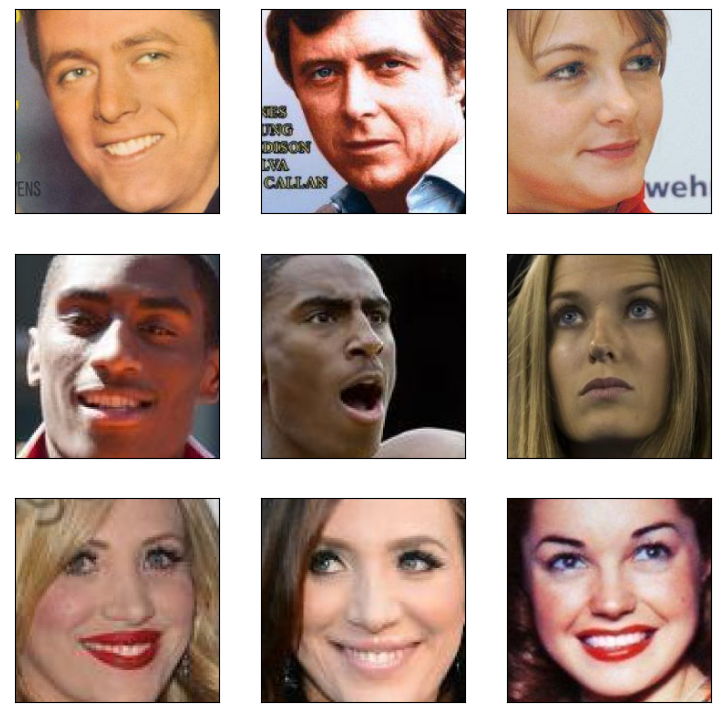

In [12]:
visualize_triplets(triplets)

### TF Pipeline

In [13]:
def preprocessing(anchor, positive, negative):
    return (
        convert_to_img(anchor),
        convert_to_img(positive),
        convert_to_img(negative)
    )


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = resnet50.preprocess_input(img)
    return img

In [14]:
features = tf.data.Dataset.from_tensor_slices((triplets['anchor'].values, triplets['positive'].values, triplets['negative'].values))
features = features.map(preprocessing)

fake_labels = tf.data.Dataset.from_tensor_slices(np.ones(triplets.shape[0]))

dataset = tf.data.Dataset.zip((features, fake_labels))

### Test val splits

In [15]:
train_dataset = dataset.take(round(triplets.shape[0] * train_size))
val_dataset = dataset.skip(round(triplets.shape[0] * train_size))

### Performance optimization

In [16]:
train_dataset = train_dataset \
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(buffer_size=tf.data.AUTOTUNE) \
        .cache()

val_dataset = val_dataset \
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(buffer_size=tf.data.AUTOTUNE) \
        .cache()

### Models

### Resnet 50

In [17]:
def resnet_embedding():
    input = layers.Input(shape=network_input_shape)

    base_cnn = resnet50.ResNet50(
        input_tensor=input,
        include_top=False,
        input_shape=network_input_shape,
        weights='imagenet'
    )

    for layer in base_cnn.layers[0:-3]:
        layer.trainable = False

    model = layers.Flatten()(base_cnn.output)

    model = layers.Dropout(0.6)(model)
    model = layers.Dense(512, activation="leaky_relu")(model)

    model = layers.Dense(512)(model)

    return Model(input, outputs=model, name='resnet50')

In [18]:
class TripletLoss(layers.Layer):

    def __init__(self, margin, **kwargs):
        self.margin = margin
        super().__init__(**kwargs)

    def euclidean_distance(self, x, y):
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

    def call(self, anchor, positive, negative):
        positive_distance = self.euclidean_distance(anchor, positive)
        negative_distance = self.euclidean_distance(anchor, negative)

        loss = positive_distance - negative_distance

        return tf.maximum(loss + self.margin, 0.0)

In [19]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

In [20]:
anchor_input = layers.Input(shape=network_input_shape, name='anchor_input')
positive_input = layers.Input(shape=network_input_shape, name='right_input')
negative_input = layers.Input(shape=network_input_shape, name='negative_input')

In [21]:
embedding = resnet_embedding()

distances = TripletLoss(margin=1)(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input)
)

model = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=distances,
    name='resnet50',
)

In [22]:
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss=identity_loss,
)

In [23]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                         

In [24]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### a) Loading model

In [25]:
# !ls ./saved_models

In [26]:
# model = load_model(model_path)

### b) Training and saving a new model

### Callbacks

In [47]:
tensorboard = TensorBoard(
    log_dir=f"logs/{model.name}_{time.strftime('run_%Y_%m_%d-%H_%M_%S')}",
    # histogram_freq=1,
    # embeddings_freq=1,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

lr_scheduler_reduce = ReduceLROnPlateau(factor=0.5, patience=5)

In [48]:
callbacks_list = [
    early_stopping,
    lr_scheduler_reduce,
    tensorboard,
]

In [49]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=callbacks_list,
    epochs=50,
)

Epoch 1/50
219/219 [==============================] - 55s 253ms/step - loss: 1.0068 - val_loss: 1.2414 - lr: 1.0000e-06
Epoch 2/50
219/219 [==============================] - 56s 256ms/step - loss: 0.9997 - val_loss: 1.2372 - lr: 1.0000e-06
Epoch 3/50
219/219 [==============================] - 57s 260ms/step - loss: 0.9554 - val_loss: 1.2320 - lr: 1.0000e-06
Epoch 4/50
219/219 [==============================] - 58s 263ms/step - loss: 0.8846 - val_loss: 1.2309 - lr: 1.0000e-06
Epoch 5/50
219/219 [==============================] - 58s 265ms/step - loss: 0.8973 - val_loss: 1.2229 - lr: 1.0000e-06
Epoch 6/50
219/219 [==============================] - 58s 267ms/step - loss: 0.8271 - val_loss: 1.2219 - lr: 1.0000e-06
Epoch 7/50
219/219 [==============================] - 59s 268ms/step - loss: 0.7869 - val_loss: 1.2169 - lr: 1.0000e-06
Epoch 8/50
219/219 [==============================] - 58s 267ms/step - loss: 0.7596 - val_loss: 1.2113 - lr: 1.0000e-06
Epoch 9/50
219/219 [====================

### Save model

In [75]:
save_path = 'saved_models'
model_version = f'{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

model_path = f'{save_path}/{model_version}'
model.save(model_path)

INFO:tensorflow:Assets written to: saved_models/resnet50-20221212-154835/assets


INFO:tensorflow:Assets written to: saved_models/resnet50-20221212-154835/assets


### Performance evaluation

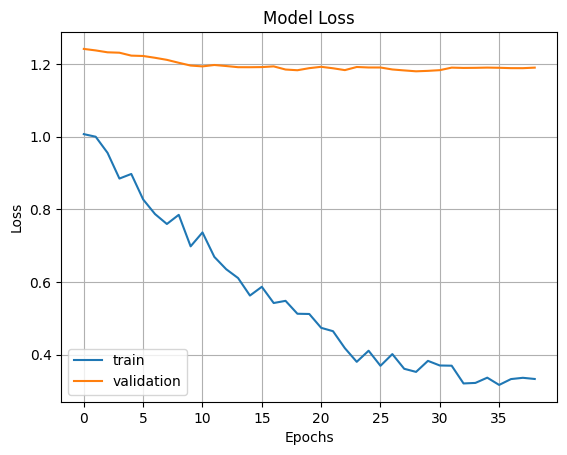

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

### Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=logs

Launching TensorBoard...

### Predictions

In [ ]:
def create_balanced_pairs(df_identity, images):
    pairs = []

    for triplet in range(images):
        anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)

        positive_pair = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True).to_list()
        negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)

        positive_pair[0] = str(celeba_path) + '/' + positive_pair[0]
        positive_pair[1] = str(celeba_path) + '/' + positive_pair[1]
        negative = str(celeba_path) + '/' + negative

        pairs.append([positive_pair[0], positive_pair[1], 1])
        pairs.append([positive_pair[0], negative, 0])

    return pd.DataFrame(pairs, columns=['left', 'right', 'label'])

In [ ]:
pairs = create_balanced_pairs(df_identity, 500)

In [ ]:
pairs.head(6)

In [ ]:
def visualize_pairs(pairs):
    def show(ax, path):
        img = cv2.imread(path)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(5, 15))

    axs = fig.subplots(6, 2)
    for i in range(6):
        show(axs[i, 0], pairs.iloc[i][0])
        show(axs[i, 1], pairs.iloc[i][1])

In [ ]:
visualize_pairs(pairs)

In [ ]:
def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [ ]:
test_ds_left = create_singular_dataset(pairs['left'])
test_ds_right = create_singular_dataset(pairs['right'])
test_labels = pairs['label']

In [ ]:
left_image_feature_vectors = embedding.predict(test_ds_left)
right_image_feature_vectors = embedding.predict(test_ds_right)

In [ ]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [ ]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
positive_mean = pd.Series(positive_distances).mean()
pd.Series(positive_distances).describe()

In [ ]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
negative_mean = pd.Series(negative_distances).mean()
pd.Series(negative_distances).describe()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [ ]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred.flatten() < cutoff
    return np.mean(pred == y_true), pred

In [ ]:
y_pred = np.linalg.norm(left_image_feature_vectors-right_image_feature_vectors, axis=1)
cutoff = (positive_mean + negative_mean)/2

In [ ]:
test_accuracy, y_pred = compute_accuracy(test_labels, y_pred, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

In [ ]:
c_matrix = confusion_matrix(y_pred, test_labels, labels=[1, 0])
c_matrix_df = pd.DataFrame(c_matrix, index=["TP", "FN"], columns=["FP", "TN"])
plt.figure(figsize=(10, 7))
sn.heatmap(c_matrix_df, cmap="Greens", annot=True,
           annot_kws={'fontsize': 20, 'fontweight': 'bold', 'alpha': 0.6},
           fmt='g')

In [ ]:
report = classification_report(y_pred, test_labels)
print(report)